# 1.Score-based Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

# https://arxiv.org/abs/2006.10739
# Gaussian random features + 时间维度 embeding
class TimeEncoding(nn.Module):
    def __init__(self, embed_dim, scale = 30.0):
        super().__init__()
        # 高斯随机特征 不需要梯度
        #https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=yC49nk6ZXqOS 
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad = False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        # 拼接sin2wxt
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim = -1)

# mlp 扩充输出维度
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
    # U-net based
    def __init__(self, marginal_prob_std, channels = [32, 64, 128, 256], embed_dim = 256):
        super().__init__()
        # 高斯时间编码
        self.embed = nn.Sequential(TimeEncoding(embed_dim = embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        # encoder
        # in_channels, out_channels, kernel_size
        # channel nums: 1-32-64-128-256
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        
        # decoder
        # in_channels, out_channels, kernel_size
        # channel nums: 256-128
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        # skip connection
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        # skip connection
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        # skip connection
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        # activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
    
    def forward(self, x, t):
         # 时间编码
        embed = self.act(self.embed(t))
        # Encoding path
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
#         print(h1.size())
        # Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
#         print(h2.size())
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
#         print(h3.size())
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
#         print(h4.size())
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        # Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


<p>SDE: $dx=f(x,t)dt+g(t)dw$
<p>demo代码中$f=0, g(t) = σ^t$
<p>SDE: $dx =\sigma^tdw$ $t\in[0,1]$( 属于VESDE，一般VESDE形式: $dx = \sqrt{\frac{d\sigma^2}{dt}}dw$，取$\sigma=\sqrt{\frac{1}{2ln\sigma}}\sigma ^t$即可得到)
<p>逆向SDE:
<p>$dx=[f(x,t)−g^2(t)\nabla_tlogp_t(x)]dt+g(t)dw$
<p>$f=0$时，逆向SDE为：$dx = -\sigma^{2t}·\nabla_tlogp_t(x)dt + σ^tdw$
<p>根据SDE数学公式，可得先验分布 $p_{0t}(x(t)|x(0))=\pmb{N}(x(t);x(0),\frac{1}{2log\sigma}(\sigma^{2t}-1)\pmb{I})$
<p>理想加噪后初值$x(0)$信息被噪声淹没，故$p_{t=1}=\pmb{N}(x;0,\frac{1}{2log\sigma}(\sigma^2-1)\pmb{I})$


In [5]:
device = 'cuda'
def marginal_prob_std(t, sigma):
    """计算t时刻加噪的高斯分布标准差, 对应上述公式 p_0t"""
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """计算t时刻扩散系数，对应σ^t"""
    return torch.tensor(sigma**t, device=device)

sigma =  25.0
#构建无参函数，方便调用
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [3]:
# test size changes
test_input=torch.rand(1,1,28, 28).cuda()
t = torch.rand(1).cuda()
model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).cuda()
output = model(test_input, t)
print(output.size())

torch.Size([1, 32, 26, 26])
torch.Size([1, 64, 12, 12])
torch.Size([1, 128, 5, 5])
torch.Size([1, 256, 2, 2])
torch.Size([1, 1, 28, 28])


C:\Users\lzh\AppData\Local\Temp\ipykernel_9316\524960296.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


<p>得分匹配: $\lambda(t){\Vert s_\theta(\widetilde{x},\sigma)-\nabla_\widetilde{x}log(p_{0t}(\widetilde{x}|x))\Vert_2}^2$
<p>同时：$p_{0t}(x(t)|x(0))=\pmb{N}(x(t);x(0),\sigma I^2)$
<p>重参数化：$\widetilde{x} = x + \sigma*z$，其中$z\sim N(0,1)$
<p>梯度可化为：$\nabla_\widetilde{x}log(p_{0t}(\widetilde{x}|x))\Vert_2=-\frac{\widetilde{x}-x}{\sigma^2}$
<p>损失函数为：$\lambda(t){\Vert s_\theta(\widetilde{x},\sigma)+\frac{\widetilde{x}-x}{\sigma^2}\Vert_2}^2$
<p>其中按照经验，最优$s_{\theta^*}$ 与$\frac{1}{\sigma}$成正比，如果取$\lambda(t)=\sigma^2$，此时$\sigma s_\theta\propto1$，且有$\frac{\widetilde{x}-x}{\sigma}\sim N(0,1)$
<p>所以此时得分匹配结果与$\sigma$无关，为理想情况，故$\lambda(t)^2=\sigma^2$
<p>此时损失函数为：$L={\Vert \sigma s_\theta(\widetilde{x},\sigma)+z\Vert_2}^2$

In [6]:

def loss_fn(score_model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.
    marginal_prob_std: 加噪的噪声分布
    eps: 数值稳定性
    """
    # step1: 从[eps, 1]中生成batchsize个t
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # step2: 重参数化采样出符合p_t分布的随机样本
    z = torch.randn_like(x) #生成与x维度一致的z
    std = marginal_prob_std(random_t) #获取标准差
    perturbed_x = x + z * std[:, None, None, None] #重参数化技巧，得到概率分布p_0t
    # step3: 输入网络，预测得分函数，得到网络输出值
    score = score_model(perturbed_x, random_t)
    # step4: 构建损失函数
    # dim1、2、3代表通道维、宽度维、长度维
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

# 2.Training Score-based Model on MNIST data

In [9]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
# 模型
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
n_epochs = 50
## size of a mini-batch
batch_size = 32
## learning rate
lr=1e-4 
# # MNIST数据集下载及读取
# dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# # Adam梯度下降
# optimizer = Adam(score_model.parameters(), lr=lr)
# # 显示进度条
# tqdm_epoch = tqdm.notebook.trange(n_epochs)
# for epoch in tqdm_epoch:
#     avg_loss = 0.
#     num_items = 0
#     # 本次是无条件建模，y没有用到
#     for x, y in data_loader:
#         x = x.to(device)
#         # 计算loss
#         loss = loss_fn(score_model, x, marginal_prob_std_fn)
#         # 清空上一次梯度
#         optimizer.zero_grad()
#         # 反向传播
#         loss.backward()
#         # 梯度下降更新
#         optimizer.step()
#         # 更新batch平均损失
#         avg_loss += loss.item() * x.shape[0]
#         num_items += x.shape[0]
#     # 打印每个epoch损失
#     tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#     # 更新checkpoint
#     torch.save(score_model.state_dict(), f'ckpt_{epoch}.pth')

# 3.Solve the reverse-time SDE
<p>逆向SDE为：$dx = -\sigma^{2t}·\nabla_tlogp_t(x)dt + σ^tdw$
<p>将对数梯度替换为Score-based Model:$dx = -\sigma^{2t}·s_\theta (x_t,t)dt + \sigma^tdw$
<p>根据欧拉法数值求解该SDE：$x_{t-\Delta t}-x_t = \sigma^{2t}·s_\theta (x_t,t)\Delta t+\sigma^t\sqrt{\Delta t}z$，其中$z\sim N(0,1)$

## 3.1 Euler-Maruyama-sampler

In [5]:
# 欧拉法
num_steps =  500
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size = 64,
                           num_steps = num_steps,
                           device = 'cuda',
                           eps = 1e-3):
    # step 1:初始化
    # 初始时间
    t = torch.ones(batch_size, device=device)
    # 初始样本 重参数化
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
        * marginal_prob_std(t)[:, None, None, None]
    # step 2:步长
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    # step 3:欧拉法求解
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            # 获得当前的time step
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # 获得当前的扩散系数
            g = diffusion_coeff(batch_time_step)
            # 欧拉法公式
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
        # 取最后一步的期望值为输出，即最后一步不需要添加随机项，认为它已经达到最优
        return x_mean

## 3.2 Predictor-Corrector-sampler
<p>通过欧拉法与郎之万融合，提高生成质量
<p>欧拉数值解为Predictor，郎之万为Corrector，用来降低误差
<p>伪代码：
    <p>$\qquad$ $for\quad i = N - 1 \quad to \quad 0 \quad do$
        <p>$\qquad$$\qquad$$x_i \gets Predictor(x_{i+1})$
        <p>$\qquad$$\qquad$$for \quad j = 1 \quad to \quad M \quad do$
            <p>$\qquad$$\qquad$$\qquad$$x_i \gets Corrector(x_i)$
    <p>$\qquad$$return \quad x_0$

In [6]:
signal_to_noise_ratio = 0.16
num_steps =  500
m_steps = 20
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size = 64,
               num_steps = num_steps,
               m_steps = m_steps,
               snr = signal_to_noise_ratio,
               device = 'cuda',
               eps = 1e-3):
    # step 1：初始化
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    # step 2：步长
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    # step 3：PC-sampler
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            # 获得当前的time step
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            ## get the langevin step size
            # yang song 2020：文章算法中是二范数相除乘以信噪比
            grad = score_model(x, batch_time_step)
            # 但文章中建议采用 average norm across the mini-batch
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim = -1).mean()
            # 但文章中建议采用 sqrt(d)
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            # langevin step size
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
#             print(f"langevin step size = {langevin_step_size}")
            for _ in range (m_steps):
                # langevin iterations formula
                x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
                grad = score_model(x, batch_time_step)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim = -1).mean()
                noise_norm = np.sqrt(np.prod(x.shape[1:]))
                langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
                
            # Predictor
            # 获得当前的扩散系数
            g = diffusion_coeff(batch_time_step)
            # 欧拉法公式
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
            # 取最后一步的期望值为输出，即最后一步不需要添加随机项，认为它已经达到最优
        return x_mean

## 3.3 ODE solver
<p>SDE: $dx = σ^tdw$ 
<p>该SDE对应唯一一条ODE：$dx = -\frac{1}{2}\sigma ^{2t}s_\theta (x_t, t)dt$
<p>通过调用python提供的ODE solver求解，例如 scipy

In [83]:
from scipy import integrate
error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size = 64,
                atol = error_tolerance,
                rtol = error_tolerance,
                device = 'cuda',
                z = None,
                eps=1e-3):
    t = torch.ones(batch_size, device=device)
    # step 1：初始化
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
        * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z

    shape = init_x.shape
    
    # step 2：定义ODE
    # 获取得分函数
    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
    # 根据公式计算ODE
    def ode_func(t, x):
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

    # step 3：调用ODE solver
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device = device).reshape(shape)

    return x


## 3.4 Generating through sampler

C:\Users\lzh\AppData\Local\Temp\ipykernel_15552\524960296.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
C:\Users\lzh\AppData\Local\Temp\ipykernel_15552\524960296.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 320
<function ode_sampler at 0x000001FDFEF28A60>耗时1.452070951461792s


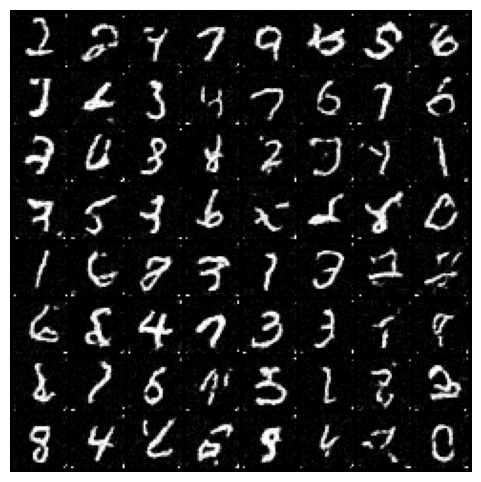

In [84]:
from torchvision.utils import make_grid
import time
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
file_epoch = n_epochs - 1 
ckpt = torch.load(f'check_points/ckpt_{file_epoch}.pth', map_location = device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 
#Euler_Maruyama_sampler pc_sampler ode_sampler
sampler = ode_sampler

t1 = time.time()
## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)
t2 = time.time()
print(f"{str(sampler)}耗时{t2-t1}s")
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# 4.Result
## 4.1 Euler_Maruyama-sampler
耗时：1.496110200881958s
![Euler_Maruyama](./result/Euler_Maruyama.png)
## 4.2.PC-sampler
耗时：29.643242120742798s
![pc_langevin20](./result/pc_langevin20.png)
## 4.3 ODE-sampler
耗时：1.1010806560516357s
![ODE](./result/ode.png)